## Transfer Learning with ResNet50 for image classification

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

### Global Constants

In [0]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout


### ResNet50

In [0]:
num_classes = 2
image_resize = 224


### Define Our Transfer Learning Network Model Consisting of 2 Layers

In [0]:
# Start a new Keras Sequential model.
model = Sequential()

# 1st layer
model.add(ResNet50(include_top=True, pooling='avg', weights='imagenet'))

# Add a dropout-layer which may prevent overfitting.
model.add(Dropout(0.5))

# Add layer as Dense for 2-class classification
model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

W0720 16:12:09.038343 139897031812992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


102858752/102853048 [==============================] - 1s 0us/step


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2002      
Total params: 25,638,714
Trainable params: 2,002
Non-trainable params: 25,636,712
_________________________________________________________________


### Compile Our Transfer Learning Model

In [0]:
num_epochs = 5

# These steps value should be proper FACTOR of number of images in train & test
batch_size_training = 100
batch_size_validation = 40


In [0]:
from tensorflow.python.keras import optimizers

optimizer = optimizers.Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [0]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Prepare Keras Data Generators

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dir = '../gdrive/My Drive/room-testing/train'
test_dir = '../gdrive/My Drive/room-testing/test'

In [0]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = image_resize

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        directory=train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size_training,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        directory=test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size_validation,
        class_mode='categorical') 


Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [0]:
# These steps value should be proper FACTOR of number of images in train & test
steps_per_epoch_training = train_generator.n / batch_size_training
steps_per_epoch_validation = validation_generator.n / batch_size_validation
steps_per_epoch_training

40.0

In [0]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / batch_size_training'
# len(valid_generator) should be 'no. of available train images / batch_size_validation'
(batch_size_training, len(train_dir), batch_size_validation, len(test_dir))


(100, 37, 40, 36)

### Train Our Model

In [0]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch_training,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=steps_per_epoch_validation,
)

Epoch 1/5
40/40 [==============================] - 1492s 37s/step - loss: 0.6913 - acc: 0.6210 - val_loss: 0.6782 - val_acc: 0.7625
Epoch 2/5
40/40 [==============================] - 1172s 29s/step - loss: 0.6869 - acc: 0.7477 - val_loss: 0.6597 - val_acc: 0.9262
Epoch 3/5
40/40 [==============================] - 1173s 29s/step - loss: 0.6827 - acc: 0.8060 - val_loss: 0.6417 - val_acc: 0.9362
Epoch 4/5
40/40 [==============================] - 1173s 29s/step - loss: 0.6784 - acc: 0.8152 - val_loss: 0.6233 - val_acc: 0.9350
Epoch 5/5
40/40 [==============================] - 1174s 29s/step - loss: 0.6745 - acc: 0.8205 - val_loss: 0.6057 - val_acc: 0.9300


In [0]:
result = model.evaluate_generator(validation_generator, 
                                  steps=steps_per_epoch_validation)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 93.00%


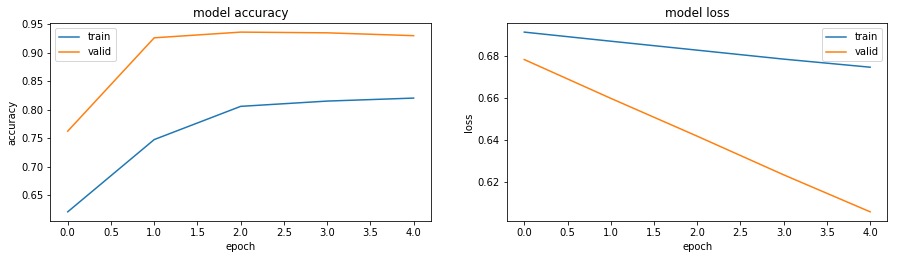

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [0]:
'''import tensorflow as tf

saving_model = tf.keras.models.save_model(
   model,
   '/gdrive/My Drive/Colab Notebooks/resnet_room_total_4.h5py',
   overwrite=True,
   include_optimizer=True,
   save_format=None
)'''